<a href="https://colab.research.google.com/github/vincent1rookie/RL-Lab/blob/master/Policy_Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Policy Gradient

## 1.  Model

In [0]:
"""
Policy Gradient Reinforcement Learning
"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


class PolicyGradientAgent:

    def __init__(self, name: str, n_action: int, n_obs: int, units_layer: tuple, learning_rate=1e-4, gamma=0.99, seed=1,
                 save_path=None, load_path=None):
        """
        To initialize an agent based on policy gradient

        :param name: name
        :param n_action: dimension of action space
        :param n_obs: dimension of state space
        :param units_layer: number of hidden layers and numbers of units in each layer
        :param learning_rate: learning rate of optimizer
        :param gamma: reward discount
        :param seed: random seed
        :param save_path: path to save model variables
        :param load_path: path to reload model variables
        """
        self.name = name
        self.n_action = n_action
        self.n_obs = n_obs
        self.n_layer = len(units_layer)
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.initializer = tf.contrib.layers.xavier_initializer(seed=seed)
        self.units_layer = (self.n_obs,) + units_layer + (self.n_action,)
        self.sess = tf.Session()
        self.x_list, self.y_list, self.r_list = [], [], []
        self.r_history, self.l_history = [], []
        self.episode = 0

        # Initialize input placeholders
        with tf.variable_scope(self.name+'_input', reuse=tf.AUTO_REUSE):
            self.input_x = tf.placeholder(tf.float32, [None, self.n_obs], name='input_x')
            self.input_y = tf.placeholder(tf.int32, name='input_y')
            self.input_r = tf.placeholder(tf.float32, name='input_r')

        # Initialize weights and bias in each layers
        with tf.variable_scope(self.name+'_params', reuse=tf.AUTO_REUSE):
            self.W, self.b = [], []
            for i in range(self.n_layer+1):
                self.W.append(tf.get_variable('W'+str(i), [self.units_layer[i], self.units_layer[i+1]]))
                self.b.append(tf.get_variable('b'+str(i), [1, self.units_layer[i+1]]))

        # Initialize hidden layers
        with tf.variable_scope(self.name+'_layers', reuse=tf.AUTO_REUSE):
            self.layer = [self.input_x]
            for i in range(self.n_layer+1):
                if i < self.n_layer:
                    self.layer.append(tf.nn.relu(tf.add(tf.matmul(self.layer[i], self.W[i]), self.b[i])))
                else:
                    self.layer.append(tf.add(tf.matmul(self.layer[i], self.W[i]), self.b[i]))

        # Initialize outputs
        with tf.variable_scope(self.name + '_output', reuse=tf.AUTO_REUSE):
            self.output_prob = tf.nn.softmax(self.layer[-1])

        # Define loss function
        with tf.variable_scope(self.name+'_loss', reuse=tf.AUTO_REUSE):
            self.neg_log_prob = tf.reduce_sum(tf.log(self.output_prob) *
                                              tf.one_hot(self.input_y, self.n_action), axis=1)
            self.loss = -tf.reduce_mean(self.input_r * self.neg_log_prob)

        # Initialize optimizer
        with tf.variable_scope(self.name+r'_op', reuse=tf.AUTO_REUSE):
            self.op = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)

        # Try to save and/or reload model
        self.save_path = save_path
        self.saver = tf.train.Saver()
        if load_path is not None:
            self.load_path = load_path
            self.saver.restore(self.sess, self.load_path)
        else:
            self.sess.run(tf.global_variables_initializer())

    def act(self, obs):
        """
        To make an action when received a new observation.

        :param obs: observation
        :return: an int indicating corresponding action
        """
        prob = self.sess.run(self.output_prob, feed_dict={self.input_x: obs.reshape([1, self.n_obs])})
        return np.random.choice(range(self.n_action), p=prob.ravel())

    def record(self, state: np.ndarray, action: int, reward: float):
        """
        To record a transition of (s,a,r)
        """
        self.x_list.append(state.reshape([1, self.n_obs]))
        self.y_list.append(action)
        self.r_list.append(reward)

    def discount_reward(self):
        """
        To discount the reward
        """
        discount_r = np.zeros_like(self.r_list)
        running_add = 0
        for i in reversed(range(len(self.r_list))):
            running_add = running_add * self.gamma + self.r_list[i]
            discount_r[i] = running_add
        discount_r -= np.mean(discount_r)
        discount_r /= np.std(discount_r)
        return discount_r

    def learn(self, popup=5):
        """
        To train the model after each episode

        :param popup: period length to print the reward and loss
        """
        epx = np.vstack(self.x_list)
        epy = np.hstack(self.y_list)
        epr = self.discount_reward()

        self.sess.run(self.op, feed_dict={self.input_x: epx, self.input_y: epy, self.input_r: epr.flatten()})

        self.r_history.append(np.sum(self.r_list))
        self.l_history.append(
            self.sess.run(self.loss, feed_dict={self.input_x: epx, self.input_y: epy, self.input_r: epr.flatten()}))
        self.x_list, self.y_list, self.r_list = [], [], []
        self.episode += 1
        if self.episode % 5 == 0:
            print('Average reward for episode %d to %d: %f'
                  % (self.episode-popup, self.episode, np.mean(self.r_history[:self.episode-popup-1:-1])))
            print('Average loss for episode %d to %d: %f'
                  % (self.episode-popup, self.episode, np.mean(self.l_history[:self.episode-popup-1:-1])))

    def plot_cost(self):
        """
        To print the loss change after each training episode
        """
        plt.plot(np.arange(len(self.l_history)), self.l_history)
        plt.ylabel('Loss')
        plt.xlabel('Training Steps')
        plt.show()

    def plot_reward(self):
        """
        To print the reward change after each training episode
        """
        plt.plot(np.arange(len(self.r_history)), self.r_history)
        plt.ylabel('Reward')
        plt.xlabel('Training Steps')
        plt.show()

    def save(self):
        """
        To save the model
        """
        if self.save_path is not None:
            self.saver.save(self.sess, self.save_path)
        else:
            print("Save Path needed")


## 2. Initialize the environment dependencies

gym environment is not integrated in colab, so we need to install relevant dependencies. 

Also, according to official documents, we need to rewrite render functions so that the result can be rendered in notebook.
.

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install box2d-py
!pip install gym[Box_2D]

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (41.0.1)


In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## 3. Training Step

In [5]:
env =gym.make("LunarLander-v2")

# Policy gradient has high variance, seed for reproducability
env.seed(1)

print("env.action_space", env.action_space)
print("env.observation_space", env.observation_space)
print("env.observation_space.high", env.observation_space.high)
print("env.observation_space.low", env.observation_space.low)
EPISODES = 5000
rewards = []

# Load checkpoint
load_version = 0
save_version = load_version + 1
load_path = "LunarLander-v1.ckpt"
save_path = "LunarLander-v1.ckpt"

Agent = PolicyGradientAgent(
    n_obs=env.observation_space.shape[0],
    n_action=env.action_space.n,
    units_layer=(25,),
    learning_rate=3e-3,
    name='LunarLander2',
    gamma=0.99,
    load_path=None,
    save_path=save_path
)

for episode in range(EPISODES):

    observation = env.reset()
    episode_reward = 0

    # tic = time.clock()

    while True:
        # 1. Choose an action based on observation
        action = Agent.act(observation)

        # 2. Take action in the environment
        state, reward, done, info = env.step(action)

        # 3. Store transition for training
        Agent.record(observation, action, reward)

        observation = state

        if done:
            episode_rewards_sum = sum(Agent.r_list)
            rewards.append(episode_rewards_sum)
            max_reward_so_far = np.amax(rewards)

            # 4. Train neural network
            Agent.learn()
            break
# 5. Save thr model                
Agent.save()

env.action_space Discrete(4)
env.observation_space Box(8,)
env.observation_space.high [inf inf inf inf inf inf inf inf]
env.observation_space.low [-inf -inf -inf -inf -inf -inf -inf -inf]

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average reward for episode 0 to 5: nan
Average loss for episode 0 to 5: nan
Average reward for episode 5 to 10: -337.352603
Average loss for episode 5 to 10: -0.058094
Average reward for episode 10 to 15: -332.376999
Average loss for episode 10 to 15: -0.086364
Average reward for episode 15 to 20: -339.826982
Average loss for episode 15 to 20: -0.013294
Average reward for episode 20 to 25: -252.623061
Average loss for episode 20 to 25: -0.003550
Average reward for episode 25 to 30: -174.724738
Average loss for episode 25 to 30: 0.006844
Average reward for episode 30 to 35: -138.289468
Average loss for episode 30 to 35: -0.049189
Average reward for episode 35 to 40: -124.440561
Average loss for episode 35 to 40: 0.056209
Average reward for episode 40 to 45: -210.736284
Average loss for episode 40 to 45: 0.020305
Average reward for episode 45 to 50: -175.713397
Average loss for episode 45 to 50: -0.023111
Average reward for episode 50 to 55: -114.122189
Average loss for episode 50 to 55:

ValueError: ignored

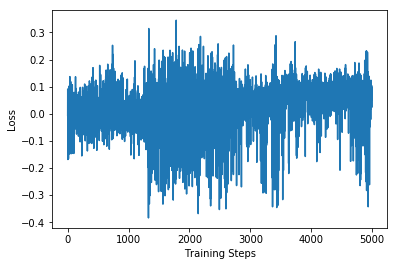

In [6]:
Agent.plot_cost()

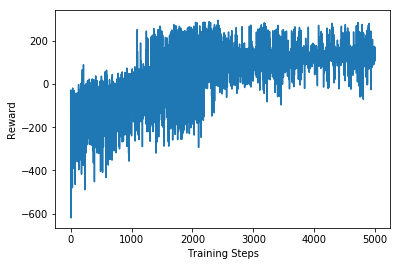

In [7]:
Agent.plot_reward()

In [10]:
env = wrap_env(gym.make("LunarLander-v2"))
observation = env.reset()

while True:
  
    env.render()
    
    #your agent goes here
    action = Agent.act(observation)
         
    observation, reward, done, info = env.step(action) 
   
        
    if done: 
      break;
            
env.close()
show_video()

In [0]:
Agent.save()